In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor
import os
from torchvision.io import read_image
from torch.utils.data import DataLoader
import csv
import random
import cv2
import mimetypes
import fnmatch
from torchvision import transforms
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import time
from progress.bar import IncrementalBar
from tqdm.notebook import tqdm_notebook
import torchvision

## Downloading NotCats images

In [10]:
# root_dir = '../../Data/cats_vs_not_cats/'
# im_dataset = torchvision.datasets.Places365(root_dir, small = True, download = True)

## Checking pictures 

In [13]:
f = open('imgs_to_delete.txt', 'w')
folder = []
for i in os.walk('../../Data/cats_vs_not_cats'):
    folder.append(i)
for address, dirs, files in folder:
    for file in files:
        if mimetypes.guess_type(file)[0] == 'image/jpeg':
            try:
                im = read_image(os.path.join(address, file)) 
            except Exception:
                f.write(os.path.join(address, file) + '\n')
f.close()
with open('imgs_to_delete.txt', 'rb+') as filehandle:
    filehandle.seek(-1, os.SEEK_END)
    filehandle.truncate()

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1157 extraneous bytes before marker 0xd9
Corrupt JPEG data: 237 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


In [14]:
with open('imgs_to_delete.txt', 'r') as f:
    img_paths = f.read().split('\n') 
    
for path in img_paths:
    os.remove(path)

### Make a file with paths

In [2]:
f = open('paths.txt', 'w')
folder = []
for i in os.walk('../../Data/cats_vs_not_cats'):
    folder.append(i)
for address, dirs, files in folder:
    for file in files:
        if mimetypes.guess_type(file)[0] == 'image/jpeg':
            f.write(os.path.join(address, file) + '\n') 
f.close()
with open('paths.txt', 'rb+') as filehandle:
    filehandle.seek(-1, os.SEEK_END)
    filehandle.truncate()

In [3]:
print(folder[0][1])

['.ipynb_checkpoints', 'Cat', 'NotCat']


### Count Images

In [4]:
not_cats_number = len(fnmatch.filter(os.listdir('../../Data/cats_vs_not_cats/NotCat/airfield'), '*.jpg'))
not_cats_number += len(fnmatch.filter(os.listdir('../../Data/cats_vs_not_cats/NotCat/airplane_cabin'), '*.jpg'))
not_cats_number += len(fnmatch.filter(os.listdir('../../Data/cats_vs_not_cats/NotCat/airport_terminal'), '*.jpg'))
cats_number = len(fnmatch.filter(os.listdir('../../Data/cats_vs_not_cats/Cat/'), '*.jpg'))
    
print('Amount of not cats: ', not_cats_number)
print('Amount of cats: ', cats_number)

Amount of not cats:  10867
Amount of cats:  12405


### Split & view distributions

In [5]:
labels_map = {
    "NotCat": 0,
    "Cat": 1,
}

In [6]:
with open('paths.txt', 'r') as file:
    img_paths = file.read().split('\n')
    
img_paths = np.array(img_paths)
y = []
for item in img_paths:
    label = item.split("/")[4]
    y.append(labels_map[label])
    
train_paths, val_test_paths, y_train, y_val_test = train_test_split(img_paths, y, train_size=0.8,
                                                     random_state=42, stratify=y)

val_paths, test_paths, y_val, y_test = train_test_split(val_test_paths, y_val_test,
                                                          test_size=0.5,random_state=42,
                                                          stratify=y_val_test)
print("Train size: ", train_paths.shape[0])
print("Val size: ", val_paths.shape[0])
print("Test size: ", test_paths.shape[0])

with open('train_paths.txt', 'w') as file:
    for i in range(train_paths.shape[0] - 1):
        file.write(train_paths[i] + '\n')  
    file.write(train_paths[train_paths.shape[0] - 1])
    
with open('val_paths.txt', 'w') as file:
    for i in range(val_paths.shape[0] - 1):
        file.write(val_paths[i] + '\n')  
    file.write(val_paths[val_paths.shape[0] - 1])
    
with open('test_paths.txt', 'w') as file:
    for i in range(test_paths.shape[0] - 1):
        file.write(test_paths[i] + '\n')  
    file.write(test_paths[test_paths.shape[0] - 1])

Train size:  18617
Val size:  2327
Test size:  2328


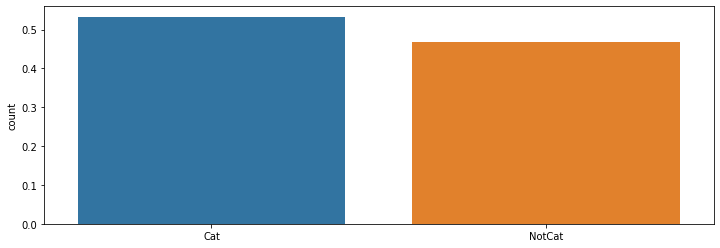

In [7]:
labels_map_inv = {
    0: "NotCat",
    1: "Cat",
}

counts = defaultdict(int)
for l in y:
    counts[labels_map_inv[l]] += 1 / img_paths.shape[0]

counts_df = pd.DataFrame.from_dict(counts, orient='index')
counts_df.columns = ['count']
counts_df.sort_values('count', ascending=False, inplace=True)

fig, ax = plt.subplots()
ax = sns.barplot(x=counts_df.index, y=counts_df['count'], ax=ax)
fig.set_size_inches(12,4)
ax.set_xticklabels(ax.xaxis.get_majorticklabels())
None

In [8]:
train_counts = defaultdict(int)
for l in y_train:
    train_counts[l] += 1 / train_paths.shape[0]

train_counts_df = pd.DataFrame.from_dict(train_counts, orient='index')
train_counts_df.columns = ['train_count']
train_counts_df.sort_values('train_count', ascending=False, inplace=True)

val_counts = defaultdict(int)
for l in y_val:
    val_counts[l] += 1 / val_paths.shape[0]

val_counts_df = pd.DataFrame.from_dict(val_counts, orient='index')
val_counts_df.columns = ['val_count']
val_counts_df.sort_values('val_count', ascending=False, inplace=True)

test_counts = defaultdict(int)
for l in y_test:
    test_counts[l] += 1 / test_paths.shape[0]

test_counts_df = pd.DataFrame.from_dict(test_counts, orient='index')
test_counts_df.columns = ['test_count']
test_counts_df.sort_values('test_count', ascending=False, inplace=True)

In [9]:
counts_df = pd.concat([train_counts_df,val_counts_df,test_counts_df], axis=1)
counts_df.head()

,train_count,val_count,test_count
1,0.533061,0.532875,0.533076
0,0.466939,0.467125,0.466924


## Examples

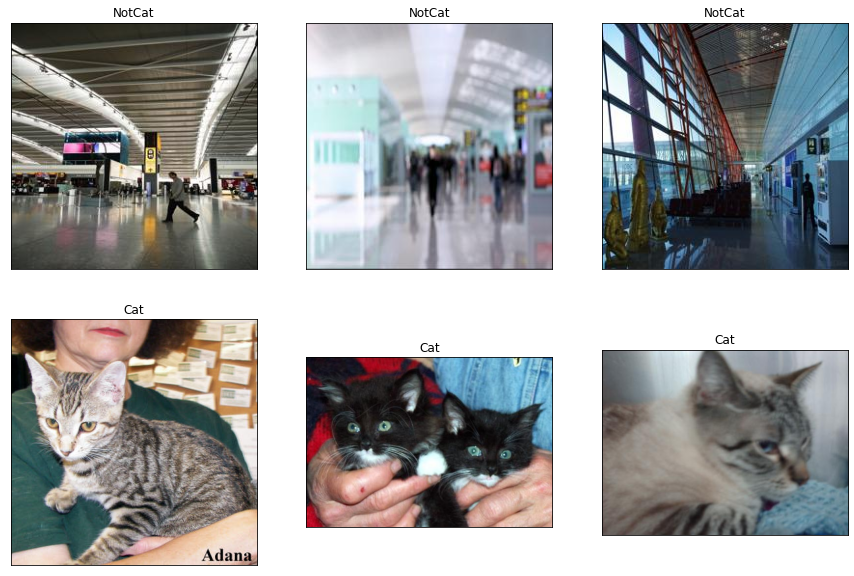

In [12]:
n = 2
m = 3

fig, ax = plt.subplots(n, m, figsize=(15, 10))
# NotCat - 1 row
counter = 0
col = 0
for i in range(len(img_paths)):
    if counter < m and y[i] == 0:
        img = Image.open(img_paths[i])
        ax[0][col].get_xaxis().set_visible(False)
        ax[0][col].get_yaxis().set_visible(False)
        ax[0][col].set_title("NotCat")
        ax[0][col].imshow(img)
        counter += 1
        col += 1
    elif counter >= m:
        break
# Cat - 2 row
counter = 0
col = 0
for i in range(len(img_paths)):
    if counter < m and y[i] >= 1:
        img = Image.open(img_paths[i])
        ax[1][col].get_xaxis().set_visible(False)
        ax[1][col].get_yaxis().set_visible(False)
        ax[1][col].set_title("Cat")
        ax[1][col].imshow(img)
        counter += 1
        col += 1
    elif counter >= m:
        break

plt.show()

In [11]:
from PIL import Image